In [54]:
import pandas as pd
import numpy as np
%pylab inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rc('axes.formatter', useoffset=False)
from scipy import stats
import seaborn as sns
from ggplot import *
import statsmodels.api as sm
from statsmodels.formula.api import ols

matplotlib.rc('axes.formatter', useoffset=False)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


sale = pd.read_csv('sale.csv') 
rent = pd.read_csv('rent.csv')
ned ={'Victoria Island':'VI', 
      'Abule Egba':'Abule-Egba', 
      'Amuwo Odofin':'Amuwo-Odofin', 
      'Iddo Island':'Iddo-Island', 
      'Victoria Garden City': 'VGC',
      'Lagos Island': 'Lagos-Island',
      'Ibeju Lekki': 'Ibeju-Lekki',
      'Ifako Ijaiye': 'Ifako-Ijaiye'}

for i,j in ned.iteritems():
        sale['Address']= sale['Address'].str.replace(i, j)
        rent['Address']= rent['Address'].str.replace(i, j)



Populating the interactive namespace from numpy and matplotlib


In [55]:
#Classify the address of a properties into their various neighboorhood i.e "7, chevy view, Lekki phase 1, lekkt, lagos" to "Lekki"

#A  list of all the neighboorhoods in lagos
Place= pd.read_csv('neighboorhoods.txt')
Place = Place['Neighboorhood'].astype(str).values.tolist()

#Extract the Neighboorhood of each property from the Address column into a new column: Neighboorhood
sale['Neighboorhood'] = sale.iloc[:, 3].str.extract('(' + '|'.join(Place) + ')', expand=False)
rent['Neighboorhood'] = rent.iloc[:, 3].str.extract('(' + '|'.join(Place) + ')', expand=False)

# remove unwanted text from the Price column
remove_string = {' / year': '', 
                 ' / sqm': '',
                 ' / sqf': '',
                 ' / day': '',
                 ',':''}

for i,j in remove_string.iteritems():
    sale['Price'] = sale['Price'].str.replace(i, j)
    rent['Price'] = rent['Price'].str.replace(i, j)

#check for empty values in the dataset
nan_rows = rent[rent.isnull().T.any().T]

sale['Price'] = sale['Price'].astype(float)
rent['Price'] = rent['Price'].astype(float)

#rent.to_csv('rent_2.csv')
#sale.to_csv('sale_2.csv')           


   Neighboorhood   avgsale_price  count_sale  avgrent_price  count_rent  count
0     Abule-Egba   793563186.813          91    1253571.429          98     91
1          Agege    65565217.391          92    1178214.286          56     56
2           Ajah   108854718.358         690    1041328.829         444    444
3        Alapere    38809047.619          63    1140235.294          85     63
4       Alimosho    47120879.121          91     579870.690         116     91
5   Amuwo-Odofin  1118604845.362         199     998549.640         139    139
6          Apapa 26303458333.333          60   16702858.065          31     31
7        Badagry   524803333.333          45    1377058.824          17     17
8         Bariga    42686111.111          18     512181.818          55     18
9         Ejigbo    32647058.824          17    1325000.000           6      6
10           Epe    21448809.524          42   12000000.000           1      1
11       Gbagada    54198214.286         168    1327

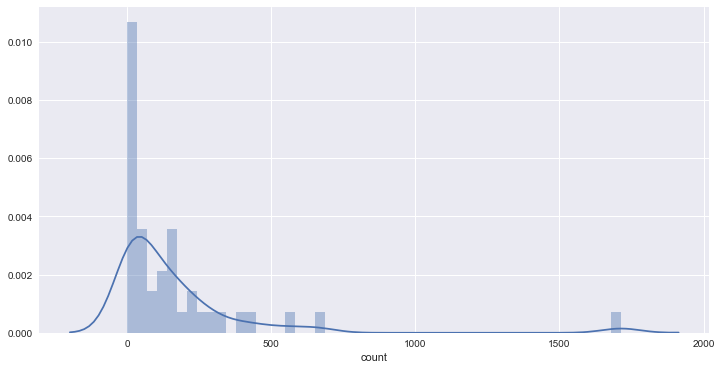

In [62]:
# for sale

group = sale.groupby('Neighboorhood')
avg_priceSale = pd.DataFrame(group['Price'].agg('mean'))
avg_priceSale.columns = ['Price']
avg_priceSale['count']=group['Price'].agg('count')
avg_priceSale = avg_priceSale.reset_index()

# for rent

group = rent.groupby('Neighboorhood')
avg_priceRent = pd.DataFrame(group['Price'].agg('mean'))
avg_priceRent.columns = ['Price']
avg_priceRent['count']=group['Price'].agg('count')
#avg_priceRent.reset_index(level='Neighboorhood', inplace=True)
avg_priceRent = avg_priceRent.reset_index()


#Merge the two datasets  (avg_priceSale and avg_priceRent)
dfMerge = pd.merge(avg_priceSale, avg_priceRent, on='Neighboorhood')
dfMerge['count']=dfMerge[['count_x','count_y']].min(axis=1)
dfMerge.columns = ['Neighboorhood', 'avgsale_price', 'count_sale', 'avgrent_price', 'count_rent', 'count']
#print dfMerge

dfMerge['avgsale_price'] = dfMerge['avgsale_price'].astype(float)
dfMerge['avgrent_price'] = dfMerge['avgrent_price'].astype(float)

print dfMerge

sns.set(rc={"figure.figsize": (12, 6)})
sns.distplot(dfMerge['count'], bins=50)
dfMerge=dfMerge.loc[dfMerge['count']>=5,]







<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 40
Data columns (total 9 columns):
Neighboorhood    38 non-null object
avgsale_price    38 non-null float64
count_sale       38 non-null int64
avgrent_price    38 non-null float64
count_rent       38 non-null int64
count            38 non-null int64
norm_resid       38 non-null float64
outlier          38 non-null object
name             38 non-null object
dtypes: float64(3), int64(3), object(3)
memory usage: 3.5+ KB


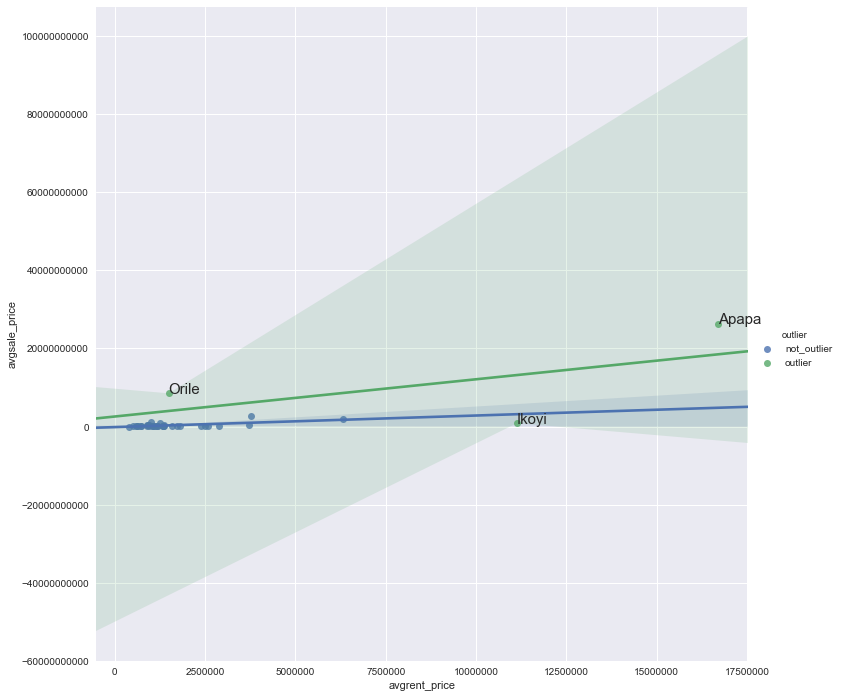

In [63]:
#model = ols("unitPrice_Sale ~ unitPrice_Rent", data=dfMerge).fit()
#sns.regplot(x="rent_price", y="sale_price", data=dfMerge, ax=ax)

#dfMerge.index=dfMerge['Neighboorhood']
model = ols("avgsale_price ~ avgrent_price", data=dfMerge).fit()

dfMerge['norm_resid']=abs(model.resid_pearson)
dfMerge['outlier']=np.where(abs(model.resid_pearson)>=2,'outlier','not_outlier')
dfMerge['name']=""
dfMerge.loc[dfMerge['norm_resid']>=2,'name']=dfMerge.loc[dfMerge['norm_resid']>=2,'Neighboorhood']

x=dfMerge['avgrent_price']
y=dfMerge['avgsale_price']
labels=dfMerge['name']



ax = sns.lmplot(x='avgrent_price', y='avgsale_price', data=dfMerge, hue='outlier', size=10)
sns.plt.ticklabel_format(style='plain',useOffset=False)
for label, x, y in zip(labels, x, y):
    sns.plt.annotate(label, xy = (x, y),fontsize = 15)

dfMerge.info()



#matplotlib.rcParams["axes.formatter.useoffset"] = False
#ggplot(dfMerge, aes(x='rent_price',y='sale_price', color='outlier',label='name')) +\
#geom_text(hjust=0, vjust=0, size=20) +\
#geom_point() +\
#scale_y_continuous(labels='percent') +\
#xlab("Rent Unit Price") +\
#ylab("Sale Unit Price") +\
#stat_smooth(color='blue') 

  

,Neighboorhood,sale_price,rent_price,ratio
33,Orile,8511800000.000,1493750.000,0.000
6,Apapa,26303458333.333,16702858.065,0.001
5,Amuwo-Odofin,1118604845.362,998549.640,0.001
17,Ikeja,2800973993.949,3771162.496,0.001
0,Abule-Egba,793563186.813,1253571.429,0.002


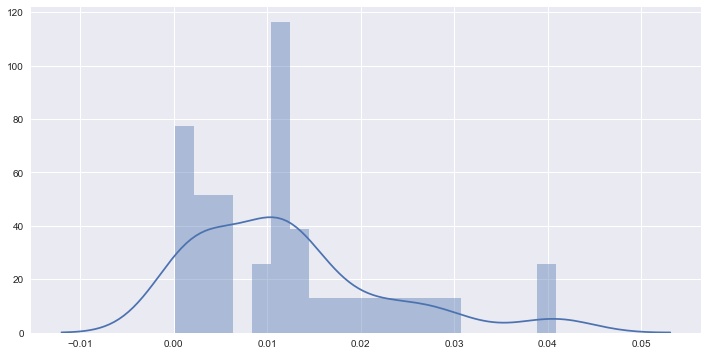

In [60]:
ratio=dfMerge['avgrent_price']/dfMerge['avgsale_price']
sns.set(rc={"figure.figsize": (12, 6)})
sns.distplot(ratio, bins=20)

dfMerge['ratio']=ratio
dfMerge=dfMerge.sort_values(['ratio'], ascending=True)
dfMerge[['Neighboorhood', 'avgsale_price','avgrent_price','ratio']][0:5]

In [61]:
dfMerge[['Neighboorhood', 'avgsale_price','avgrent_price','ratio']][::-1][0:5]

,Neighboorhood,sale_price,rent_price,ratio
18,Ikorodu,70396446.797,2880600.000,0.041
9,Ejigbo,32647058.824,1325000.000,0.041
3,Alapere,38809047.619,1140235.294,0.029
35,Sangotedo,47400207.831,1337195.122,0.028
24,Kosofe,99176369.863,2492914.384,0.025


In [59]:
dfMerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 40
Data columns (total 9 columns):
Neighboorhood    38 non-null object
sale_price       38 non-null float64
count_sale       38 non-null int64
rent_price       38 non-null float64
count_rent       38 non-null int64
count            38 non-null int64
norm_resid       38 non-null float64
outlier          38 non-null object
name             38 non-null object
dtypes: float64(3), int64(3), object(3)
memory usage: 3.5+ KB
